In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [3]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)



In [4]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [5]:
dblist_all[4:5]

['baseline_v1.5_10yrs.db']

In [6]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [7]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 save_dT=False, filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        self.save_dT = save_dT
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def get_Dkl_i(self, values):
        '''kl divergence for histogram'''
        if values.any():
            values = values + 0.00001  # make each element non-zero
            prob = (values) / values.sum()  
        
            prob_uni = np.ones( len(prob) ) / len(prob)
            return np.sum( prob_uni * np.log(prob_uni / prob) )
        
        else:
            return np.NaN
        
    def get_FoM_i(self, dT_all, tmin=0, tmax=1.5/24, bins=50):
        """return FoM from array of metricValues"""
                
        dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
        Nv = len(dT_tlim)
    
        values, bins_ = np.histogram(dT_tlim, bins=bins);
    
        Dkl = self.get_Dkl_i(values)
    
        FoM_i = Nv * np.exp(-Dkl)
        
        #print(self.Nrun, len(dT_all), Nv, Dkl, FoM_i)
        return Nv, Dkl, FoM_i, dT_tlim
      
    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        #print( 'length of dataSlice', dataSlice.shape )
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        
        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        if self.save_dT:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                'dT_lim': dT_tlim
                  }
        else:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                # 'dT_lim': dT_tlim
                  }
            
        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result) 



In [8]:
def runMetric(dbname, fltpair, ipix_ms=None, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, **kwargs
             ):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsMetric( colname=colname, fltpair=fltpair, tmin=tmin, tmax=tmax, bins=bins, mag_lim=mag_lim,
                 filename=filename, dataout=dataout, **kwargs)
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



In [9]:
ipix_LMC = [2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]
ipix_SMC = [2960, 2961, 2988, 2989, 3012]
ipix_GP = [1428, 1556, 1620, 1172, 1044, 1109,  981,  916,  982,  853,  852, 788,  789,  917,  790,  725,  726,  915,  980, 1108, 1043, 1236,
        1171, 1364, 1299, 1492, 1427, 1235, 1107, 1170, 1363, 1555, 1684, 1683, 1748, 1747, 1811, 1876, 1939, 1875, 2003, 2067, 2131, 2259,
        2322, 1300,  854,  661,  660, 2066, 1938, 2194, 1619, 1491, 1554, 1682, 1810, 1874, 2002, 2193, 2258, 2514, 2694, 2577, 2449, 2386,
        2321, 1493, 1972, 1586, 1907, 1365, 2004, 1458,  879,  751, 1008, 1779, 2164, 1393, 1522, 1843, 2358, 2487, 2551, 2614, 2293, 2728,
        2779, 2907, 2826, 2780, 2869, 2868, 2827, 2422, 2673, 1715,  816, 1073, 2825, 2729, 2100, 2229, 2036, 1650,  687, 2781, 2870, 2908,
        2828, 2829, 2783, 2674, 2943, 2942, 2871, 2909, 2944, 2782, 2830, 2872,  944, 2831, 2784, 2786, 2785, 2486, 1265, 2832, 2873, 2787,
        2737, 2910, 2911, 2945, 2975, 2974, 2973, 2730, 2739, 2788, 2738, 2833, 2685, 2874, 2912, 2946, 2976, 2686, 2740, 2789, 2687, 2629,
        2741, 1587, 2630, 2569, 2506, 2570, 2568, 2505, 2879, 2838, 2839, 2794, 2745, 2881, 2840, 2880, 2917, 2916, 2915, 2877, 2914, 2876,
        2913, 2875, 2834, 2442, 2550, 3001, 3000, 2631, 2688, 2947, 2948, 2977, 2835, 2507, 2379, 2443, 2380, 2315, 2252, 2878, 2836, 2790,
        2316, 2793, 2508, 2188, 2253, 2949, 2978, 3002, 2791, 2742, 2743, 2792, 2837, 2189, 2125, 2061, 2795, 2693, 2746, 2636, 2571, 2444,
        1933, 2126, 1998, 2635, 2381, 1136, 2062, 1934, 1870, 1806, 1871, 1743, 2576, 2637, 2513, 2692, 2448, 1807, 1935, 1679, 1997, 1999,
        1744, 1616, 1488, 2747, 2744, 1678, 2632, 2689, 2690, 2950, 1615, 1680, 1552, 1489, 1424, 2450, 1551, 1330, 2691, 2633, 2572, 2509,
        2634, 2512, 2130, 3003, 2445, 2573, 2575, 2574, 2510, 2317, 2254, 2318, 2382, 2383, 2446, 2511, 2195, 2638, 2385, 2628, 1617, 2190,
        2063, 2127, 2191, 2255, 2319, 2384, 2447, 1425, 1201, 2257, 2320, 2192, 2128, 2000, 2064, 2129, 2256, 2065, 2001, 1872, 1745, 1808,
        1873, 1936, 1937, 1809, 1553, 1618, 1746, 1681, 1490, 1426, 1362, 1361, 2736, 1234, 1298, 1297, 1042,  979, 1045, 1237, 1106,  724,
        1137, 1812, 1621, 1173, 2060, 2387,  815, 2684,  622, 2421 ]

In [10]:
df = pd.read_csv('./data/Fields_nside16.csv')
# LMC, SMC
df['inLMC'] = np.isin(df['pixId'].values, ipix_LMC)
df['inSMC'] = np.isin(df['pixId'].values, ipix_SMC)
df['inGP'] = np.isin(df['pixId'].values, ipix_GP)

df.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25,inLMC,inSMC,inGP
0,0,45.0,87.075820,124.642960,24.641921,85.217963,64.413844,0,False,False,False
1,1,135.0,87.075820,125.753479,28.655621,94.800547,64.412987,0,False,False,False
2,2,225.0,87.075820,121.143387,29.592908,95.668530,68.533082,0,False,False,False
3,3,315.0,87.075820,120.187742,25.546039,84.354664,68.534126,0,False,False,False
4,4,22.5,84.149733,123.982115,21.356778,77.697559,63.791264,0,False,False,False


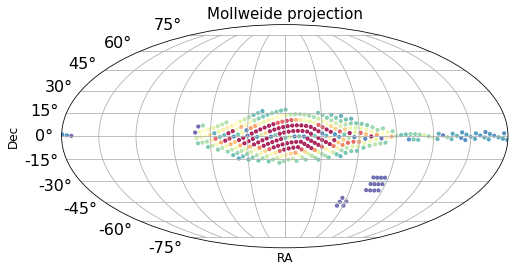

In [14]:
# plot footprint
fig, axs = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 


slicer = ( df['inLMC'] | df['inSMC'] | df['inGP'])
df_ = df[slicer]

#x = df_['fieldRa']
#y = df_['fieldDec']
x = df_['fieldGl']
y = df_['fieldGb']
#c = np.repeat(1.5, len(x))
c = df_['starDensity_r25']
plot_mwd(axs, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)

axs.set_xticklabels([]);

### test run for one opsim

In [15]:
dblist_all[18]

'descddf_v1.5_10yrs.db'

In [16]:
ipix_ms = ipix_GP
#dbname = dblist_all[4] # baseline
dbname = dblist_all[0]
# run one filter pair for baseline
metricSky = runMetric( dbname=dbname, fltpair=['u', 'r'], 
              ipix_ms=ipix_ms, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, save_dT=True)


Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 625722 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [17]:
arr = metricSky.metricValues.data 
        
df = pd.DataFrame.from_records( arr[ arr != None ] )

In [18]:
df

,Dkl,FoM_i,Nrun,Nv,dT_lim,pixId
0,9.055293,0.002686,1,23,"[0.01587254027253948, 0.015861442618188448, 0....",1428
1,7.932481,0.014356,2,40,"[0.016059276851592585, 0.015860580933804158, 0...",1556
2,8.471555,0.012142,3,58,"[0.015837794686376583, 0.017077705560950562, 0...",1620
3,8.302224,0.009423,4,38,"[0.015773154533235356, 0.014948539974284358, 0...",1172
4,7.794024,0.013602,5,33,"[0.015714165740064345, 0.015765391377499327, 0...",1044
5,8.881776,0.001667,6,12,"[0.015765719559567515, 0.01574601850734325, 0....",1109
6,8.612640,0.004363,7,24,"[0.01575894717097981, 0.03084781479992671, 0.0...",981
7,7.259480,0.021808,8,31,"[0.016233975497016218, 0.01253763336717384, 0....",916
8,NaN,NaN,9,0,[],982
9,8.246115,0.005246,10,20,"[0.015758533256303053, 0.0157443244534079, 0.0...",853


In [167]:
dbname

'filterdist_indx1_v1.5_10yrs.db'

In [175]:
data_df = get_cols(dbpath + dbname, cols='fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth')


connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/filterdist_indx1_v1.5_10yrs.db 
 SELECT fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth FROM SummaryAllProps


In [177]:
data_df['pixId'] = RADec2pix(nside=16, ra=data_df.fieldRA.values, dec=data_df.fieldDec.values )


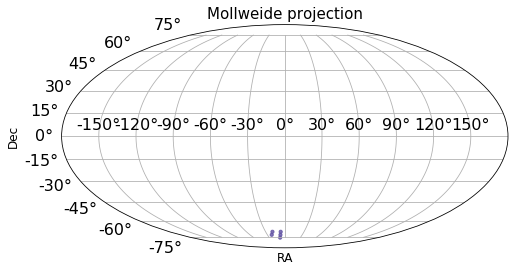

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

ra, dec = pix2radec(nside=16, ipix=ipix_SMC)
x = ra
y = dec
c = np.repeat(1.5, len(x))

plot_mwd(ax=ax, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)




### run time gaps metrics

In [19]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return np.sum( prob_uni * np.log(prob_uni / prob) )
    
    else:
        return np.NaN

def get_FoM_tgaps(df, tmin=0, tmax=1.5/24, bins=50):
    """return FoM from array of metricValues
    Inputs:
     df: pd.DataFrame, cols ['pixId', 'Dkl', 'FoM_i', 'Nv', 'dT_lim']
    """
    
    dT_all = np.concatenate(df.dT_lim.values)
    
    dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
    Nv = len(dT_tlim)

    values, bins_ = np.histogram(dT_tlim, bins=bins);

    Dkl = get_Dkl(values)

    FoM = Nv * np.exp(-Dkl)
    
    return FoM


In [20]:
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

In [21]:
%%time 
# run all filter pairs for baseline 

dicFoM = {}
dicFoM['db'] = dblist_all[4:5 ]

nside = 16
# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
sqlstr = None

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]

for fltpair in fltpairs: 
    dicFoM[fltpair] = []
    dataRaw[fltpair] = {}
    for dbname in dicFoM['db']: 
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            tmax = 1.5/24 # 1.5 hour in days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
            
        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)

        dicFoM[fltpair].append(FoM_tgaps)
        
        dataRaw[fltpair][dbname] = pd.DataFrame.from_records( arr[ arr != None ] )[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', fltpair, dbname, FoM_tgaps)
        
    df_fom = pd.DataFrame(dicFoM)
    df_fom.to_csv('tgaps_FoM_baseline_v1.5_{}.csv'.format(msname), index=False)
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/tgaps_dataRaw_baseline_v1.5_{}.pkl'.format(msname),)



Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 141843 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu baseline_v1.5_10yrs.db 1971.4759642443198
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 365714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug baseline_v1.5_10yrs.db 1806.825458839267
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 633519 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur basel

In [32]:
msname = 'GP'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_baseline_v1.5_{}.pkl'.format(msname) )


In [33]:
#df_dataRaw['ug']['baseline_v1.5_10yrs.db']

In [34]:
# get the median of N visits for each filter pair, 

Nvth = {}
for fltpair in fltpairs: 
    df = df_dataRaw[fltpair]['baseline_v1.5_10yrs.db']
    Nvth[fltpair] = np.median( df.Nv ) 
    

In [35]:
Nvth

{'uu': 990.0,
 'ug': 43.0,
 'ur': 30.0,
 'ui': 3.0,
 'uz': 0.0,
 'uy': 0.0,
 'gg': 1250.0,
 'gr': 49.0,
 'gi': 8.0,
 'gz': 0.0,
 'gy': 0.0,
 'rr': 4005.0,
 'ri': 49.0,
 'rz': 4.0,
 'ry': 0.0,
 'ii': 4095.0,
 'iz': 72.0,
 'iy': 11.0,
 'zz': 2701.0,
 'zy': 44.0,
 'yy': 2628.0}

In [36]:
starDens = np.load('../starDens16.npz')['starDens']


In [37]:
%%time 

# run for all opsims all filter pairs

dicFoMtGaps = {}
dicNfields = {}
dicNstar = {}

dbnames = dblist_all
dicFoMtGaps['db'] = dbnames
dicNfields['db'] = dbnames
dicNstar['db'] = dbnames

nside = 16

# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
sqlstr = None

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'Dkl': 0,
                'FoM_i': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]
for fltpair in fltpairs:  
    
    dicFoMtGaps[fltpair] = []
    dicNfields[fltpair] = []
    dicNstar[fltpair] = []
    
    dataRaw[fltpair] = {}
    for dbname in dbnames: 

        print('running ', dbname, fltpair)
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            tmax = 1.5/24 # 1.5 hour in days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
        
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        if len(df)==0:
            df = df_empty
        # count number of fields/stars above threshold 
        df['starDensity'] = starDens[ df['pixId'].values ] 
        idx = df['Nv'] > Nvth[fltpair]
        Nfields = df['Nv'][idx].shape[0]
        Nstar = np.sum( df['starDensity'][idx] )

        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)
                
        dicFoMtGaps[fltpair].append (FoM_tgaps)
        dicNfields[fltpair].append(Nfields)
        dicNstar[fltpair].append(Nstar)
        
        # save the raw data, 
        dataRaw[fltpair][dbname] = df[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', msname, fltpair, dbname, FoM_tgaps, Nfields, Nstar)
    
    df_fom = pd.DataFrame(dicFoMtGaps)
    df_fom.to_csv('df_tgapsFoM_{}.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNfields)
    df_fom.to_csv('df_Nfields_{}.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNstar)
    df_fom.to_csv('df_Nstar_{}.csv'.format(msname), index=False)
    
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/tgaps_dataRaw_{}.pkl'.format(msname),)



running  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 156714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu agnddf_v1.5_10yrs.db 2401.169315910707 156 56544804
running  alt_dust_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 143535 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu alt_dust_v1.5_10yrs.db 1840.4737293543578 54 19010016
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']


Found 144750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu filterdist_indx2_v1.5_10yrs.db 3256.781261083551 247 228285252
running  filterdist_indx3_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 137608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu filterdist_indx3_v1.5_10yrs.db 2059.6062111440515 247 228285252
running  filterdist_indx4_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 351270 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu filterdist_indx4_v1.5_10

Found 143123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu goodseeing_gri_v1.5_10yrs.db 2738.7128100850337 156 62337204
running  goodseeing_griz_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 142206 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu goodseeing_griz_v1.5_10yrs.db 2599.57375067357 162 61828056
running  goodseeing_gz_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 141977 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu goodseeing_gz_v1.5_10yrs.db 2106.7

Found 141536 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu third_obs_pt45v1.5_10yrs.db 2473.4531314941496 157 62690976
running  third_obs_pt60v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 141372 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu third_obs_pt60v1.5_10yrs.db 2583.4977424984886 156 58068972
running  third_obs_pt90v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 141800 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu third_obs_pt90v1.5_10yrs.db 2471.8990

Found 141634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu wfd_depth_scale0.90_v1.5_10yrs.db 3093.9261309365424 150 53468640
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 140283 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu wfd_depth_scale0.95_noddf_v1.5_10yrs.db 1795.8389094220245 148 52883532
running  wfd_depth_scale0.95_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 139304 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu w

Found 376006 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug dcr_nham2_ug_v1.5_10yrs.db 1127.7636306240815 30 41106996
running  dcr_nham2_ugr_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 375238 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug dcr_nham2_ugr_v1.5_10yrs.db 1321.5945543452751 46 60728688
running  dcr_nham2_ugri_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 375586 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug dcr_nham2_ugri_v1.5_10yrs.db 1507.76370

Found 382319 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_newBv1.5_10yrs.db 1081.0203923393387 41 38281392
running  footprint_no_gp_northv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 365007 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_no_gp_northv1.5_10yrs.db 1910.3919765572446 147 89986788
running  footprint_standard_goalsv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 365407 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_stan

Found 475777 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug short_exp_5ns_5expt_v1.5_10yrs.db 3287.9326202529455 306 255627612
running  spiders_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 366104 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug spiders_v1.5_10yrs.db 1725.5735331968247 149 83378268
running  third_obs_pt120v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 366130 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug third_obs_pt120v1.5_10yrs.db 2101.7952585

Found 373325 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug wfd_depth_scale0.80_noddf_v1.5_10yrs.db 2070.1305512135805 272 228768516
running  wfd_depth_scale0.80_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 372670 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug wfd_depth_scale0.80_v1.5_10yrs.db 2109.335966985238 256 216506160
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 367723 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug 

Found 626994 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur bulges_i_heavy_v1.5_10yrs.db 1535.6422822763864 76 29420388
running  daily_ddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 603960 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur daily_ddf_v1.5_10yrs.db 2500.375062993313 140 48336372
running  dcr_nham1_ug_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 634639 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur dcr_nham1_ug_v1.5_10yrs.db 2685.146291193659 16

Found 630549 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur footprint_big_skyv1.5_10yrs.db 159.29857567189256 18 3929940
running  footprint_big_wfdv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 636634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur footprint_big_wfdv1.5_10yrs.db 2219.5554067833577 138 42309252
running  footprint_bluer_footprintv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 636625 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur footprint_bluer_foo

Found 627194 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur rolling_mod6_sdf_0.10_v1.5_10yrs.db 2413.4524592656053 134 46692180
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 628596 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur rolling_mod6_sdf_0.20_v1.5_10yrs.db 2668.694364707955 145 56921436
running  short_exp_2ns_1expt_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 725824 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur short_ex

Found 648926 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur wfd_depth_scale0.65_v1.5_10yrs.db 3532.9208506373548 260 225685800
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 645551 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur wfd_depth_scale0.70_noddf_v1.5_10yrs.db 3501.2493278697016 267 221490828
running  wfd_depth_scale0.70_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 646087 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur

Found 638410 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui bulges_bs_v1.5_10yrs.db 240.83865089557278 60 20914236
running  bulges_bulge_wfd_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 638845 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui bulges_bulge_wfd_v1.5_10yrs.db 427.6997173370829 82 70063128
running  bulges_cadence_bs_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 637565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui bulges_cadence_bs_v1.5_10yrs.db 27

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui filterdist_indx7_v1.5_10yrs.db 1213.4491447151293 234 212103684
running  filterdist_indx8_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 616962 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui filterdist_indx8_v1.5_10yrs.db 1034.6418418750732 212 185765832
running  footprint_add_mag_cloudsv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 636784 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui footprint_add_mag_cloudsv1.5_10yrs.db 706.3817799132178 142 693

Found 637169 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 230.08538444855722 47 17504172
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 639512 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui rolling_mod2_sdf_0.10_v1.5_10yrs.db 690.245970329697 143 58312764
running  rolling_mod2_sdf_0.20_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 639633 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui rollin

Found 729743 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui twilight_neo_mod3_v1.5_10yrs.db 607.9152309582107 134 50213088
running  twilight_neo_mod4_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 705769 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui twilight_neo_mod4_v1.5_10yrs.db 637.7781025646527 132 48920976
running  u60_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 558378 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui u60_v1.5_10yrs.db 162.81249765423274 

running  agnddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 592598 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz agnddf_v1.5_10yrs.db nan 0 0
running  alt_dust_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 578526 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz alt_dust_v1.5_10yrs.db nan 0 0
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 580339 visits
Running:  ['newMetricSky']

Found 529286 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz filterdist_indx3_v1.5_10yrs.db nan 0 0
running  filterdist_indx4_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 748380 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz filterdist_indx4_v1.5_10yrs.db nan 0 0
running  filterdist_indx5_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 693519 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz filterdist_indx5_v1.5_10yrs.db nan 0 0
running  filterdist_indx6_v1.5_10y

Found 575651 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz goodseeing_gz_v1.5_10yrs.db nan 0 0
running  goodseeing_i_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 573323 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz goodseeing_i_v1.5_10yrs.db nan 0 0
running  greedy_footprint_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 567522 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz greedy_footprint_v1.5_10yrs.db nan 0 0
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.d

Found 838394 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz twilight_neo_mod1_v1.5_10yrs.db nan 0 0
running  twilight_neo_mod2_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 702368 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz twilight_neo_mod2_v1.5_10yrs.db nan 0 0
running  twilight_neo_mod3_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 661104 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz twilight_neo_mod3_v1.5_10yrs.db nan 0 0
running  twilight_neo_mod4_v1

Found 569084 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz wfd_depth_scale0.99_v1.5_10yrs.db nan 0 0
running  agnddf_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 581392 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy agnddf_v1.5_10yrs.db nan 0 0
running  alt_dust_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 585372 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy alt_dust_v1.5_10yrs.db 0.0021107859231936574 5 6230088
running  alt_roll_mod2_dust_sdf_0.20_v1.5_1

Found 601315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy filterdist_indx2_v1.5_10yrs.db 0.0006194756396805537 1 150336
running  filterdist_indx3_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 545097 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy filterdist_indx3_v1.5_10yrs.db nan 0 0
running  filterdist_indx4_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 763729 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy filterdist_indx4_v1.5_10yrs.db nan 0 0
running  fi

Found 578134 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy goodseeing_griz_v1.5_10yrs.db 0.001271922254324656 4 2458728
running  goodseeing_gz_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 578117 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy goodseeing_gz_v1.5_10yrs.db 0.019957044587825927 11 3908016
running  goodseeing_i_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 577449 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy goodseeing_i_v1.5_10yrs.db nan 0 0
ru

Found 582480 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy third_obs_pt90v1.5_10yrs.db nan 0 0
running  twilight_neo_mod1_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 711316 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy twilight_neo_mod1_v1.5_10yrs.db 0.0010284042513737535 2 1029816
running  twilight_neo_mod2_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 653628 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy twilight_neo_mod2_v1.5_10yrs.db nan 0 0
running  

Found 591961 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy wfd_depth_scale0.99_noddf_v1.5_10yrs.db nan 0 0
running  wfd_depth_scale0.99_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 595283 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy wfd_depth_scale0.99_v1.5_10yrs.db nan 0 0
running  agnddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 214351 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg agnddf_v1.5_10yrs.db 4246.895835215788 169 68038560
running  alt_dus

Found 366933 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg filterdist_indx1_v1.5_10yrs.db 5957.3836382166055 264 235401876
running  filterdist_indx2_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 210169 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg filterdist_indx2_v1.5_10yrs.db 5168.781084246228 253 230018004
running  filterdist_indx3_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 416201 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg filterdist_indx3_v1.5_10

Found 224530 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg goodseeing_gi_v1.5_10yrs.db 5762.949914159854 169 70961796
running  goodseeing_gri_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 224123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg goodseeing_gri_v1.5_10yrs.db 4450.252382364912 166 63520956
running  goodseeing_griz_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 223549 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg goodseeing_griz_v1.5_10yrs.db 3486.

Found 223608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg third_obs_pt30v1.5_10yrs.db 5591.964567065351 171 75245112
running  third_obs_pt45v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 223815 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg third_obs_pt45v1.5_10yrs.db 4380.639864039995 168 62811900
running  third_obs_pt60v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 224514 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg third_obs_pt60v1.5_10yrs.db 4551.650594

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd_depth_scale0.90_noddf_v1.5_10yrs.db 4794.789232229105 173 72648900
running  wfd_depth_scale0.90_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 223287 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd_depth_scale0.90_v1.5_10yrs.db 5456.459572035495 169 63888516
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 218388 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd_depth_scale0.95_noddf_v1.5_10yrs.db 3355.47704

Found 714808 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr dcr_nham1_ugri_v1.5_10yrs.db 3552.597557263703 166 56119428
running  dcr_nham2_ug_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 713223 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr dcr_nham2_ug_v1.5_10yrs.db 3265.248315813771 153 56359224
running  dcr_nham2_ugr_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 717313 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr dcr_nham2_ugr_v1.5_10yrs.db 3241.2265721

Found 713793 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr footprint_newAv1.5_10yrs.db 3352.019340448116 272 230196348
running  footprint_newBv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 714282 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr footprint_newBv1.5_10yrs.db 3028.0808450572144 218 184872420
running  footprint_no_gp_northv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 715433 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr footprint_no_gp_northv1.5_10y

Found 934738 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr short_exp_5ns_1expt_v1.5_10yrs.db 6775.708728961188 279 196042284
running  short_exp_5ns_5expt_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 907200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr short_exp_5ns_5expt_v1.5_10yrs.db 6781.74037980594 283 194613012
running  spiders_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 716325 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr spiders_v1.5_10yrs.db 3817

Found 733435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr wfd_depth_scale0.75_v1.5_10yrs.db 4234.072340964378 203 97481016
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 725952 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr wfd_depth_scale0.80_noddf_v1.5_10yrs.db 4322.240793015079 191 70599456
running  wfd_depth_scale0.80_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 726274 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr wfd

Found 731701 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi bulges_cadence_i_heavy_v1.5_10yrs.db 268.3997502251008 93 48155904
running  bulges_i_heavy_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 732036 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi bulges_i_heavy_v1.5_10yrs.db 655.9187602970704 93 44605908
running  daily_ddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 698307 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi daily_ddf_v1.5_10yrs.db 352.555197

Found 701832 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi footprint_big_sky_nouiyv1.5_10yrs.db 9.701104414456013 22 4865220
running  footprint_big_skyv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 728953 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi footprint_big_skyv1.5_10yrs.db 34.467339139306844 25 5331924
running  footprint_big_wfdv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 706087 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi footprint_big_wfdv1.5_10

Found 724686 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi rolling_mod3_sdf_0.20_v1.5_10yrs.db 1221.8538142838026 159 60609384
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 723630 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi rolling_mod6_sdf_0.10_v1.5_10yrs.db 1192.666295269489 151 54083124
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 722318 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi rollin

Found 747711 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi wfd_depth_scale0.65_noddf_v1.5_10yrs.db 545.1756954456326 232 132842448
running  wfd_depth_scale0.65_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 746657 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi wfd_depth_scale0.65_v1.5_10yrs.db 383.26306780702214 207 123932988
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 742411 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi 

Found 656993 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz baseline_v1.5_10yrs.db 107.04812372944659 110 66014460
running  bulges_bs_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 661137 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz bulges_bs_v1.5_10yrs.db 28.613341455431833 55 22253364
running  bulges_bulge_wfd_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 660464 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz bulges_bulge_wfd_v1.5_10yrs.db 7.937783681546572

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz filterdist_indx6_v1.5_10yrs.db 0.40650220988548813 54 45061560
running  filterdist_indx7_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 678972 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz filterdist_indx7_v1.5_10yrs.db 24.043899105247775 112 113159376
running  filterdist_indx8_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 670504 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz filterdist_indx8_v1.5_10yrs.db 40.87117359495883 104 93091788
running  

Found 649241 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz greedy_footprint_v1.5_10yrs.db 43.91274494084843 96 69178788
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 668061 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 18.632498916873086 90 68949720
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 662797 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz rolling_m

Found 795011 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz twilight_neo_mod2_v1.5_10yrs.db 46.32753081940969 89 33934392
running  twilight_neo_mod3_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 750775 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz twilight_neo_mod3_v1.5_10yrs.db 61.598465825748235 91 30777804
running  twilight_neo_mod4_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 726717 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz twilight_neo_mod4_v1.5_1

Found 645457 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz wfd_depth_scale0.99_v1.5_10yrs.db 20.943621619267415 89 35629740
running  agnddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 639029 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy agnddf_v1.5_10yrs.db 0.10386541902033951 31 12480048
running  alt_dust_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 670748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy alt_dust_v1.5_10yrs.db 1.6403802089501094 34 262110

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy filterdist_indx1_v1.5_10yrs.db 0.8372104822704057 38 54582804
running  filterdist_indx2_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 666734 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy filterdist_indx2_v1.5_10yrs.db 0.17170330038862436 27 34971840
running  filterdist_indx3_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 823690 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy filterdist_indx3_v1.5_10yrs.db 0.12450693750522956 38 36758232
running  f

Found 661161 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy goodseeing_gi_v1.5_10yrs.db 9.009537151133776 61 30234240
running  goodseeing_gri_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 659926 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy goodseeing_gri_v1.5_10yrs.db 27.219981750665564 68 76922856
running  goodseeing_griz_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 659477 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy goodseeing_griz_v1.5_10yrs.db 15.618

Found 661741 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy third_obs_pt30v1.5_10yrs.db 9.216538766977378 57 26536536
running  third_obs_pt45v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 663202 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy third_obs_pt45v1.5_10yrs.db 0.16703742690164186 41 18462312
running  third_obs_pt60v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 663979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy third_obs_pt60v1.5_10yrs.db 0.022758945

Found 656126 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy wfd_depth_scale0.90_noddf_v1.5_10yrs.db 0.0443646584792054 21 8816544
running  wfd_depth_scale0.90_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 662200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy wfd_depth_scale0.90_v1.5_10yrs.db 0.08740862575964076 31 14939136
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 662868 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy wfd

Found 490223 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr dcr_nham1_ugri_v1.5_10yrs.db 17636.317953497106 164 59744700
running  dcr_nham2_ug_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 488068 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr dcr_nham2_ug_v1.5_10yrs.db 15775.5967793139 163 59987844
running  dcr_nham2_ugr_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 491833 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr dcr_nham2_ugr_v1.5_10yrs.db 24493.899509

Found 492157 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr footprint_newAv1.5_10yrs.db 11971.441951025487 301 251394948
running  footprint_newBv1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 490417 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr footprint_newBv1.5_10yrs.db 13569.357681607034 265 241788996
running  footprint_no_gp_northv1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 491978 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr footprint_no_gp_northv1.5_10

Found 640319 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr short_exp_5ns_1expt_v1.5_10yrs.db 63658.243342447146 174 61732548
running  short_exp_5ns_5expt_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 621340 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr short_exp_5ns_5expt_v1.5_10yrs.db 62088.88420442828 173 61082604
running  spiders_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 492318 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr spiders_v1.5_10yrs.db 8533

Found 499848 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wfd_depth_scale0.75_v1.5_10yrs.db 11161.110660389606 173 61082604
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 496712 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wfd_depth_scale0.80_noddf_v1.5_10yrs.db 9280.935509473547 173 61082604
running  wfd_depth_scale0.80_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 497108 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wf

Found 993049 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri bulges_cadence_i_heavy_v1.5_10yrs.db 3052.849805318748 134 110713428
running  bulges_i_heavy_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 993441 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri bulges_i_heavy_v1.5_10yrs.db 3318.198914830701 134 109754856
running  daily_ddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 946829 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri daily_ddf_v1.5_10yrs.db 4347.4

Found 976730 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_big_sky_nouiyv1.5_10yrs.db 625.5077965473729 30 6671592
running  footprint_big_skyv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1001408 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_big_skyv1.5_10yrs.db 796.1780918852047 30 6776244
running  footprint_big_wfdv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 972028 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_big_wfdv1.5_10

Found 983617 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri rolling_mod3_sdf_0.20_v1.5_10yrs.db 6240.081949460621 168 60706980
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 983740 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri rolling_mod6_sdf_0.10_v1.5_10yrs.db 6406.190427132805 162 59485068
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 981024 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri rolling

Found 1010423 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri wfd_depth_scale0.65_noddf_v1.5_10yrs.db 5027.909705704732 260 182102760
running  wfd_depth_scale0.65_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1009258 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri wfd_depth_scale0.65_v1.5_10yrs.db 4473.869909954247 252 185354604
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1006776 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP r

Found 924798 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz baseline_v1.5_10yrs.db 572.7535642913882 161 60783408
running  bulges_bs_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 923250 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz bulges_bs_v1.5_10yrs.db 253.0008612571031 112 55011276
running  bulges_bulge_wfd_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 922879 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz bulges_bulge_wfd_v1.5_10yrs.db 577.9993219950927 

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz filterdist_indx6_v1.5_10yrs.db 1308.0216980083462 242 220166496
running  filterdist_indx7_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 862409 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz filterdist_indx7_v1.5_10yrs.db 1043.2323669473888 237 223594632
running  filterdist_indx8_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 919303 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz filterdist_indx8_v1.5_10yrs.db 637.4166383275419 217 196050528
running

Found 914583 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz greedy_footprint_v1.5_10yrs.db 475.73607371792116 172 103138236
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 918289 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 184.32443639458853 113 98614548
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 922502 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz rolli

Found 1182225 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz twilight_neo_mod2_v1.5_10yrs.db 877.180831517532 154 53950176
running  twilight_neo_mod3_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1094089 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz twilight_neo_mod3_v1.5_10yrs.db 302.04437700694507 161 57080304
running  twilight_neo_mod4_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1050304 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz twilight_neo_mod4_v1

Found 921635 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz wfd_depth_scale0.99_v1.5_10yrs.db 800.7346500673599 149 53394156
running  agnddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 893686 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry agnddf_v1.5_10yrs.db 18.298128443599413 75 24746184
running  alt_dust_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 929327 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry alt_dust_v1.5_10yrs.db 67.95890337302961 61 30747060

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry filterdist_indx1_v1.5_10yrs.db 119.42818543636034 135 131267124
running  filterdist_indx2_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 942866 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry filterdist_indx2_v1.5_10yrs.db 87.21117391292697 131 148581468
running  filterdist_indx3_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 848687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry filterdist_indx3_v1.5_10yrs.db 7.123925854491572 59 77739156
running  f

Found 928221 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry goodseeing_gi_v1.5_10yrs.db 122.50380781290221 99 43183800
running  goodseeing_gri_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 927796 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry goodseeing_gri_v1.5_10yrs.db 99.80410438758994 128 95094612
running  goodseeing_griz_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 927235 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry goodseeing_griz_v1.5_10yrs.db 301.2

Found 930176 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry third_obs_pt30v1.5_10yrs.db 48.28891089778541 87 40545216
running  third_obs_pt45v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 931366 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry third_obs_pt45v1.5_10yrs.db 82.33481227152124 89 44634564
running  third_obs_pt60v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 932518 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry third_obs_pt60v1.5_10yrs.db 27.2526940200

Found 925102 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry wfd_depth_scale0.90_noddf_v1.5_10yrs.db 140.04612488141865 103 83640312
running  wfd_depth_scale0.90_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 930292 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry wfd_depth_scale0.90_v1.5_10yrs.db 37.592663490806856 94 38222316
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 933993 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry wf

Found 495136 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii dcr_nham1_ugri_v1.5_10yrs.db 15212.455532288039 166 59958972
running  dcr_nham2_ug_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 493612 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii dcr_nham2_ug_v1.5_10yrs.db 10748.274438365315 167 60524460
running  dcr_nham2_ugr_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 491856 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii dcr_nham2_ugr_v1.5_10yrs.db 11294.1569

Found 493361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii footprint_newAv1.5_10yrs.db 7899.900250708524 296 250628040
running  footprint_newBv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 492518 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii footprint_newBv1.5_10yrs.db 8950.225784503556 267 242159616
running  footprint_no_gp_northv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 496324 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii footprint_no_gp_northv1.5_10yr

Found 647134 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii short_exp_5ns_1expt_v1.5_10yrs.db 73358.50325605631 175 62375364
running  short_exp_5ns_5expt_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 627660 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii short_exp_5ns_5expt_v1.5_10yrs.db 43093.153976604655 174 61732548
running  spiders_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 496633 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii spiders_v1.5_10yrs.db 8025

Found 502376 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii wfd_depth_scale0.75_v1.5_10yrs.db 9617.74985386156 172 60629220
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 499750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii wfd_depth_scale0.80_noddf_v1.5_10yrs.db 7798.881489099658 173 61082604
running  wfd_depth_scale0.80_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 500713 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii wfd_

Found 937515 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz bulges_cadence_i_heavy_v1.5_10yrs.db 3498.121809869492 122 99949500
running  bulges_i_heavy_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 938332 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz bulges_i_heavy_v1.5_10yrs.db 3813.5751737257006 129 103480308
running  daily_ddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 896859 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz daily_ddf_v1.5_10yrs.db 4635.2

Found 918836 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprint_big_sky_nouiyv1.5_10yrs.db 711.4857335202306 26 5893956
running  footprint_big_skyv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 944975 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprint_big_skyv1.5_10yrs.db 993.2613568175523 52 13949136
running  footprint_big_wfdv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 914848 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprint_big_wfdv1.5_10

Found 928175 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz rolling_mod3_sdf_0.20_v1.5_10yrs.db 5292.228917249767 172 61906392
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 929042 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz rolling_mod6_sdf_0.10_v1.5_10yrs.db 5888.576521262043 169 58276872
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 925581 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz rolling

Found 961026 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz wfd_depth_scale0.65_noddf_v1.5_10yrs.db 5609.436471060596 282 210143736
running  wfd_depth_scale0.65_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 951216 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz wfd_depth_scale0.65_v1.5_10yrs.db 5024.332936246921 259 165484440
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 957387 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz w

Found 933583 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy baseline_v1.5_10yrs.db 2372.381068939065 164 73932624
running  bulges_bs_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 937835 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy bulges_bs_v1.5_10yrs.db 1794.4575373581154 117 87311772
running  bulges_bulge_wfd_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 938058 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy bulges_bulge_wfd_v1.5_10yrs.db 1696.231262498141

Found 1070590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy filterdist_indx6_v1.5_10yrs.db 3038.622603993523 248 225587412
running  filterdist_indx7_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 879915 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy filterdist_indx7_v1.5_10yrs.db 3643.254437076447 254 231147036
running  filterdist_indx8_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 984989 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy filterdist_indx8_v1.5_10

Found 940358 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy greedy_footprint_v1.5_10yrs.db 2337.7267671800537 162 64281996
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 935428 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 1338.1961579429317 71 68046228
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 934001 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy rolling

Found 1129928 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy twilight_neo_mod2_v1.5_10yrs.db 1932.3066809781474 143 50731596
running  twilight_neo_mod3_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1066361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy twilight_neo_mod3_v1.5_10yrs.db 2197.4782783612645 153 57863232
running  twilight_neo_mod4_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1031315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy twilight_neo_mod4_

Found 951782 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy wfd_depth_scale0.99_v1.5_10yrs.db 2477.2388631984713 153 55828080
running  agnddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 435884 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz agnddf_v1.5_10yrs.db 10743.064797449291 170 60815268
running  alt_dust_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 434991 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz alt_dust_v1.5_10yrs.db 6003.10065728117 65 2709511

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz filterdist_indx1_v1.5_10yrs.db 16540.164444279686 264 235401876
running  filterdist_indx2_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 437267 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz filterdist_indx2_v1.5_10yrs.db 15979.727495093834 264 235401876
running  filterdist_indx3_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 391678 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz filterdist_indx3_v1.5_10yrs.db 10420.51159079263 264 235401876
running

Found 431356 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz goodseeing_gi_v1.5_10yrs.db 11501.151108059343 169 60661944
running  goodseeing_gri_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 431364 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz goodseeing_gri_v1.5_10yrs.db 8256.71203402025 167 60484860
running  goodseeing_griz_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 432894 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz goodseeing_griz_v1.5_10yrs.db 10952

Found 433440 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz third_obs_pt30v1.5_10yrs.db 11520.926456226362 167 60519420
running  third_obs_pt45v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 433665 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz third_obs_pt45v1.5_10yrs.db 10969.384777536487 169 60631164
running  third_obs_pt60v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 433610 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz third_obs_pt60v1.5_10yrs.db 8994.3628

Found 441431 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz wfd_depth_scale0.90_noddf_v1.5_10yrs.db 14540.501233867151 170 60720624
running  wfd_depth_scale0.90_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 432928 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz wfd_depth_scale0.90_v1.5_10yrs.db 7832.188234943144 167 60468552
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 438874 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz wf

Found 867689 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy dcr_nham1_ugri_v1.5_10yrs.db 6118.927699912563 167 75172428
running  dcr_nham2_ug_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 865899 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy dcr_nham2_ug_v1.5_10yrs.db 6311.654808258513 171 92320956
running  dcr_nham2_ugr_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 865686 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy dcr_nham2_ugr_v1.5_10yrs.db 5695.1020863

Found 864347 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_newAv1.5_10yrs.db 6337.404921634892 297 250917840
running  footprint_newBv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 866683 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_newBv1.5_10yrs.db 5323.865360434786 252 236263860
running  footprint_no_gp_northv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 870756 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_no_gp_northv1.5_10yr

Found 1128194 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy short_exp_5ns_1expt_v1.5_10yrs.db 9629.91874862101 245 199697652
running  short_exp_5ns_5expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 1096444 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy short_exp_5ns_5expt_v1.5_10yrs.db 9457.43908018122 216 120250476
running  spiders_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 873711 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy spiders_v1.5_10yrs.db 634

Found 845242 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy wfd_depth_scale0.75_v1.5_10yrs.db 5844.712520665962 237 165609288
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 856831 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy wfd_depth_scale0.80_noddf_v1.5_10yrs.db 6628.357822501557 212 127482120
running  wfd_depth_scale0.80_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 854880 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy w

Found 437942 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy bulges_cadence_i_heavy_v1.5_10yrs.db 9184.879047557575 133 106289748
running  bulges_i_heavy_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 438454 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy bulges_i_heavy_v1.5_10yrs.db 6819.337032218109 134 106739712
running  daily_ddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 421433 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy daily_ddf_v1.5_10yrs.db 9120.5

Found 441250 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy footprint_big_sky_nouiyv1.5_10yrs.db 1095.9021543736678 32 7183836
running  footprint_big_skyv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 432177 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy footprint_big_skyv1.5_10yrs.db 1144.0915999626818 32 7183836
running  footprint_big_wfdv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 460560 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy footprint_big_wfdv1.5_1

Found 442903 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy rolling_mod3_sdf_0.20_v1.5_10yrs.db 11695.236324303763 162 61897032
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 454040 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy rolling_mod6_sdf_0.10_v1.5_10yrs.db 12749.727646623505 162 61067664
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 454174 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy rolli

Found 377932 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy wfd_depth_scale0.65_noddf_v1.5_10yrs.db 9321.244132186477 308 256847544
running  wfd_depth_scale0.65_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 385219 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy wfd_depth_scale0.65_v1.5_10yrs.db 15475.469186654334 305 255403944
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 387634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy 

In [295]:
len( dicFoMtGaps['ug'] )

85

In [289]:
dicNfields

{'db': ['agnddf_v1.5_10yrs.db',
  'alt_dust_v1.5_10yrs.db',
  'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
  'baseline_2snaps_v1.5_10yrs.db',
  'baseline_v1.5_10yrs.db',
  'bulges_bs_v1.5_10yrs.db',
  'bulges_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_bs_v1.5_10yrs.db',
  'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_i_heavy_v1.5_10yrs.db',
  'bulges_i_heavy_v1.5_10yrs.db',
  'daily_ddf_v1.5_10yrs.db',
  'dcr_nham1_ug_v1.5_10yrs.db',
  'dcr_nham1_ugr_v1.5_10yrs.db',
  'dcr_nham1_ugri_v1.5_10yrs.db',
  'dcr_nham2_ug_v1.5_10yrs.db',
  'dcr_nham2_ugr_v1.5_10yrs.db',
  'dcr_nham2_ugri_v1.5_10yrs.db',
  'descddf_v1.5_10yrs.db',
  'filterdist_indx1_v1.5_10yrs.db',
  'filterdist_indx2_v1.5_10yrs.db',
  'filterdist_indx3_v1.5_10yrs.db',
  'filterdist_indx4_v1.5_10yrs.db',
  'filterdist_indx5_v1.5_10yrs.db',
  'filterdist_indx6_v1.5_10yrs.db',
  'filterdist_indx7_v1.5_10yrs.db',
  'filterdist_indx8_v1.5_10yrs.db',
  'footprint_add_mag_cloudsv1.5_10yrs.db',
  'footprint_big_sky_du

In [283]:
fltpairs

['uu',
 'ug',
 'ur',
 'ui',
 'uz',
 'uy',
 'gg',
 'gr',
 'gi',
 'gz',
 'gy',
 'rr',
 'ri',
 'rz',
 'ry',
 'ii',
 'iz',
 'iy',
 'zz',
 'zy',
 'yy']

In [282]:
arr

array([{'Nrun': 1, 'pixId': 2960, 'Nv': 16, 'Dkl': 9.389035094784543, 'FoM_i': 0.0013381778918751632, 'dT_lim': array([0.03486494, 0.01622914, 0.01663874, 0.03445455, 0.01581876,
       0.01622835, 0.016427  , 0.01637211, 0.01577378, 0.01580907,
       0.01580081, 0.01579388, 0.01629143, 0.01587913, 0.01670415,
       0.01629185])},
       {'Nrun': 2, 'pixId': 2961, 'Nv': 14, 'Dkl': 9.259228921712946, 'FoM_i': 0.0013332021590298263, 'dT_lim': array([0.01629517, 0.01547095, 0.01577593, 0.0162343 , 0.01584717,
       0.04710375, 0.01584275, 0.03891336, 0.01580825, 0.01580039,
       0.01712061, 0.01629639, 0.01578351, 0.01666315])},
       {'Nrun': 3, 'pixId': 2988, 'Nv': 6, 'Dkl': 9.141422083075629, 'FoM_i': 0.0006428091986966666, 'dT_lim': array([0.01629154, 0.01579341, 0.01584644, 0.01577392, 0.01642766,
       0.01580075])},
       {'Nrun': 4, 'pixId': 2989, 'Nv': 9, 'Dkl': 8.84198637092099, 'FoM_i': 0.0013008182446101583, 'dT_lim': array([0.01666357, 0.01580157, 0.0380909 , 0.015842

In [278]:
dicNfields['uu']

[1, 3, 0]

In [122]:
df

""


In [121]:
dblist_all

['agnddf_v1.5_10yrs.db',
 'alt_dust_v1.5_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
 'baseline_2snaps_v1.5_10yrs.db',
 'baseline_v1.5_10yrs.db',
 'bulges_bs_v1.5_10yrs.db',
 'bulges_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_bs_v1.5_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_i_heavy_v1.5_10yrs.db',
 'bulges_i_heavy_v1.5_10yrs.db',
 'daily_ddf_v1.5_10yrs.db',
 'dcr_nham1_ug_v1.5_10yrs.db',
 'dcr_nham1_ugr_v1.5_10yrs.db',
 'dcr_nham1_ugri_v1.5_10yrs.db',
 'dcr_nham2_ug_v1.5_10yrs.db',
 'dcr_nham2_ugr_v1.5_10yrs.db',
 'dcr_nham2_ugri_v1.5_10yrs.db',
 'descddf_v1.5_10yrs.db',
 'filterdist_indx1_v1.5_10yrs.db',
 'filterdist_indx2_v1.5_10yrs.db',
 'filterdist_indx3_v1.5_10yrs.db',
 'filterdist_indx4_v1.5_10yrs.db',
 'filterdist_indx5_v1.5_10yrs.db',
 'filterdist_indx6_v1.5_10yrs.db',
 'filterdist_indx7_v1.5_10yrs.db',
 'filterdist_indx8_v1.5_10yrs.db',
 'footprint_add_mag_cloudsv1.5_10yrs.db',
 'footprint_big_sky_dustv1.5_10yrs.db',
 'footprint_big_s

In [268]:
dataRaw

{'uu': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.441504  0.121022  561
  1   2961  7.956633  0.184975  528
  2   2988  8.771589  0.103281  666
  3   2989  8.167952  0.159099  561
  4   3012  7.952372  0.197375  561,
  'descddf_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.702763  0.098845  595
  1   2961  8.340162  0.118412  496
  2   2988  8.886447  0.052258  378
  3   2989  8.231738  0.167626  630
  4   3012  7.913657  0.285258  780,
  'filterdist_indx1_v1.5_10yrs.db':    pixId  Dkl  FoM_i  Nv
  0   2960    0      0   0
  1   2961    0      0   0
  2   2988    0      0   0
  3   2989    0      0   0
  4   3012    0      0   0},
 'ug': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId        Dkl     FoM_i  Nv
  0   2960  10.031224  0.001056  24
  1   2961  10.181962  0.001060  28
  2   2988  10.416150  0.000838  28
  3   2989  10.576983  0.000841  33
  4   3012   9.626473  0.002177  33,
  'descddf_v1.5_10yrs.db':    pixId        Dkl    

In [273]:
msname = 'SMC'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_{}.pkl'.format(msname) )


In [274]:
df_dataRaw

,uu,ug,ur
dcr_nham2_ugri_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 10...,pixId Dkl FoM_i Nv 0 2960 8.2...
descddf_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 9...,pixId Dkl FoM_i Nv 0 2960 8.7...
filterdist_indx1_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...


In [275]:
df_dataRaw.loc['filterdist_indx1_v1.5_10yrs.db']['uu']

,pixId,Dkl,FoM_i,Nv
0,2960,0,0,0
1,2961,0,0,0
2,2988,0,0,0
3,2989,0,0,0
4,3012,0,0,0


### utils

In [12]:

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

In [13]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df
